# Week 11 - Introduction to Modeling, part 2

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

### Random Forest Classifier

In [ ]:
# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report
)

# preprocess data
motion_df = pd.read_csv("capstone_datasets/nfl-playing-surface-analytics/MotionData.csv")

# 1. Prepare the features (drop leakage columns)
X = motion_df.drop(columns=[
    'Injury', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42', 'PlayKey', 'PlayerKey', 'GameID'
])

# 2. One-hot encode categorical columns
X = pd.get_dummies(X, dummy_na=True, drop_first=True)

# For a cuDF DataFrame with some boolean columns:
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('int32')


# 3. Prepare the binary target (0 = no injury, 1 = injury)
y = motion_df['Injury'].copy()
y_binary = y.copy()
y_binary[y_binary > 0] = 1

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_binary, 
    test_size=0.2,     # 20% of data will be held out for testing
    random_state=42,   # For reproducibility
    shuffle=True       # Data is shuffled by default; can be set to False if needed
)

# Initialize and train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

Test Accuracy: 0.9996629087231732


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53374
           1       1.00      0.25      0.40        24

    accuracy                           1.00     53398
   macro avg       1.00      0.62      0.70     53398
weighted avg       1.00      1.00      1.00     53398



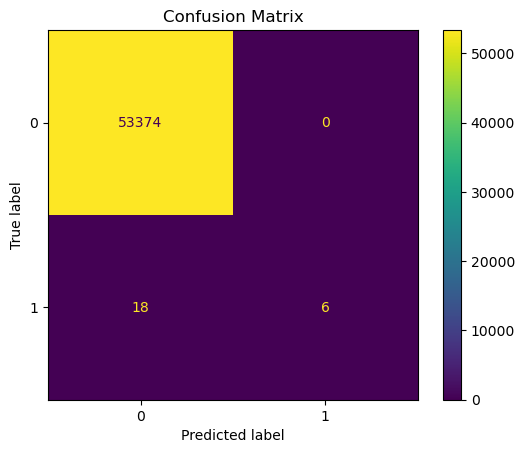

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# 8. Predict and evaluate
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show() # great accuracy but very poor recal

### Resampling with SMOTE, then Cross Validation through GridSearchCV

In [16]:
import time
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Start timing
start_time = time.time()

# Define the pipeline: first SMOTE, then the classifier.
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=0))
])

# Parameter grid for grid search.
grid_params = {
    'classifier__max_depth': [2, 3, 4, 5, None],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__min_samples_split': [2, 3, 4],
    'classifier__max_features': [2, 3, 4],
    'classifier__n_estimators': [75, 100, 125, 150]
}

# Define the scoring metrics (ensure 'scoring' is defined appropriately).
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Initialize GridSearchCV.
grid_cv = GridSearchCV(pipeline, 
                       grid_params, 
                       scoring=scoring, 
                       cv=3,
                       n_jobs=-1, 
                       refit='f1',
                       verbose=3)

# Fit on the training data.
grid_cv.fit(X_train, y_train)

# Print execution time.
execution_time = time.time() - start_time
print(f"\nExecution Time: {execution_time:.2f}s\n")

# Print the best parameters and best f1 score.
print("Best Parameters:")
print(grid_cv.best_params_)
print(f"\nBest F1 Score (CV): {grid_cv.best_score_:.4f}\n")

# Display all cross-validation results in a sorted DataFrame.
cv_results = pd.DataFrame(grid_cv.cv_results_)
# Sort by rank_test_f1 (lowest rank is the best)
cv_results = cv_results.sort_values('rank_test_f1')
print("Grid Search CV Results (top 5 rows):")
print(cv_results[['params', 'mean_test_f1', 'std_test_f1', 'rank_test_f1']].head())

# If you have a test set, evaluate on it:
if 'X_test' in globals() and 'y_test' in globals():
    y_pred = grid_cv.predict(X_test)
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix on Test Set:")
    print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV 1/3] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=125; f1: (test=0.254) precision: (test=0.205) recall: (test=0.333) total time=   7.1s
[CV 1/3] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=3, classifier__n_estimators=75; f1: (test=0.171) precision: (test=0.115) recall: (test=0.333) total time=   7.4s
[CV 3/3] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=75; f1: (test=0.412) precision: (test=1.000) recall: (test=0.259) total time=   9.6s
[CV 2/3] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=3, classifier__n_estimators=75; f1: (test=0.333) precision: (test=0.667) recall: (te

/home/pshmo/miniconda3/envs/datasci/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/3] END classifier__max_depth=None, classifier__max_features=2, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=75; f1: (test=0.353) precision: (test=0.857) recall: (test=0.222) total time=  23.5s
[CV 1/3] END classifier__max_depth=None, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=3, classifier__n_estimators=100; f1: (test=0.500) precision: (test=1.000) recall: (test=0.333) total time=  54.6s
[CV 3/3] END classifier__max_depth=None, classifier__max_features=2, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=75; f1: (test=0.412) precision: (test=1.000) recall: (test=0.259) total time=  26.1s
[CV 3/3] END classifier__max_depth=None, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=3, classifier__n_estimators=150; f1: (test=0.412) precision: (test=1.000) recall: (test=0.259) total time=  52.8s
[CV 1/3] END classifie

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.